<a href="https://colab.research.google.com/github/kridtapon/DonchiRSI/blob/main/DonchiRSI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.5/527.5 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 71.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 45.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.43.0
    Uninstalling llvmlite-0.43.0:
      Successfully uninstalled llvmlite-0.43.0
  Attempting uninstall: numba
    Found existing installation: numba 0.60.0
    Uninstalling numba-0.60.0:
      Successfully uninst

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import matplotlib.pyplot as plt

In [2]:
# Function to calculate Donchian Channels with randomness in the window size
def calculate_donchian_channels(df, window=20):
    df['Upper'] = df['High'].rolling(window=window).max()
    df['Lower'] = df['Low'].rolling(window=window).min()
    df['Middle'] = (df['Upper'] + df['Lower']) / 2
    return df

In [3]:
# Function to calculate RSI with randomness in the window size
def calculate_rsi(df, window=14):
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    return df

[*********************100%***********************]  1 of 1 completed


Best Donchian Window: 12
Best RSI Window: 25
Mean Return: 0.9331
Standard Deviation of Return: 0.5228
Maximum Return: 2.2063
Minimum Return: 0.2039
Mean Maximum Drawdown: -0.2721
Standard Deviation of Maximum Drawdown: 0.0639
Most Severe Maximum Drawdown: -0.3372
Least Severe Maximum Drawdown: -0.1712


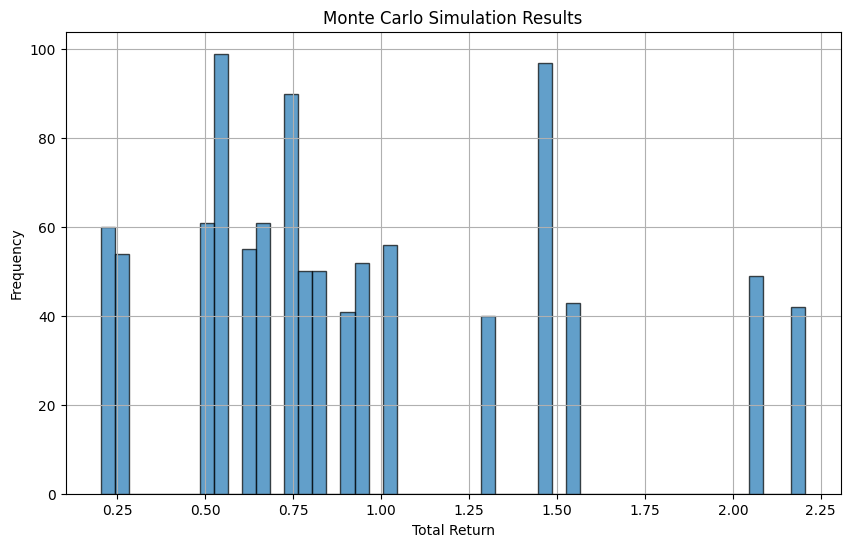

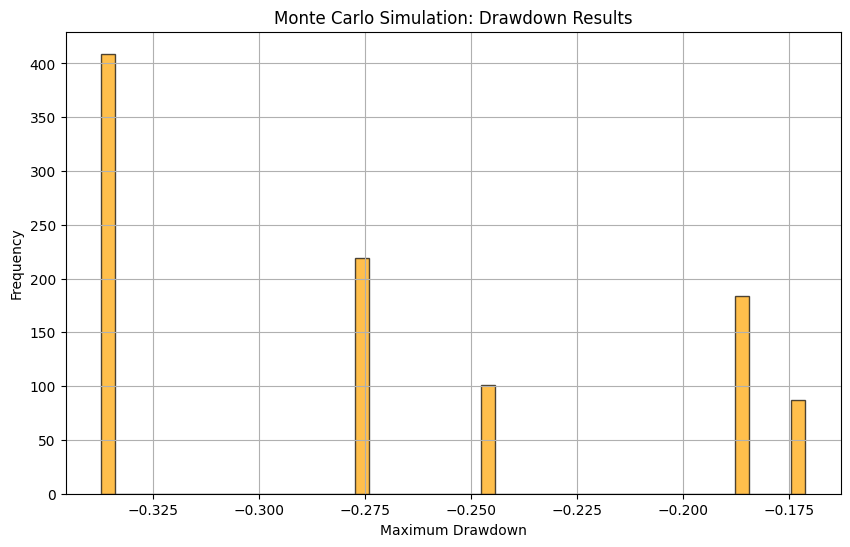

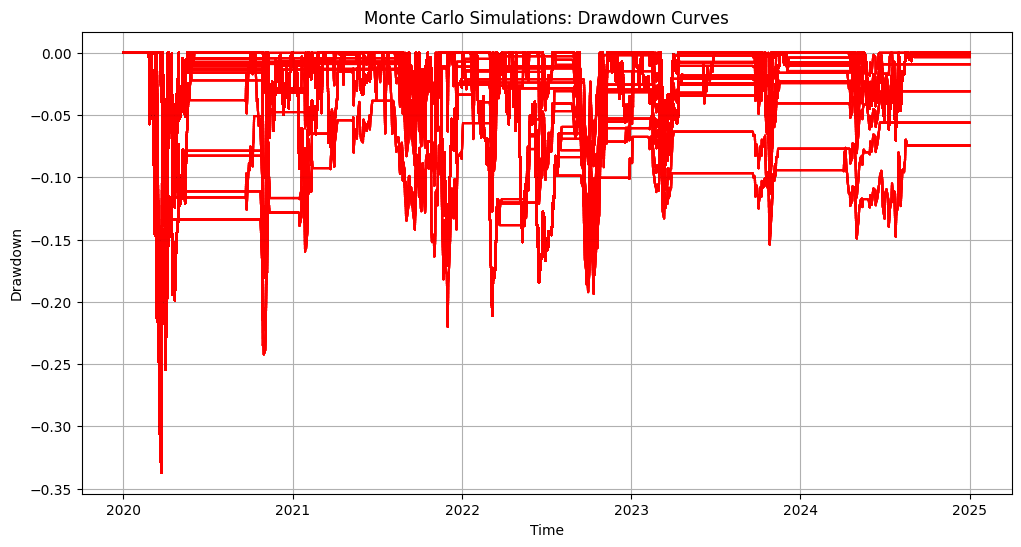

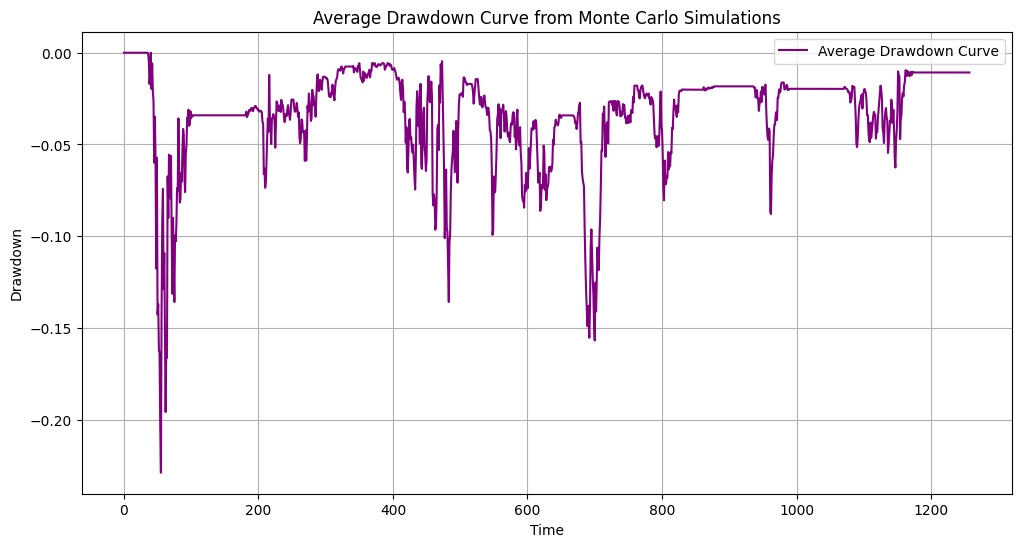

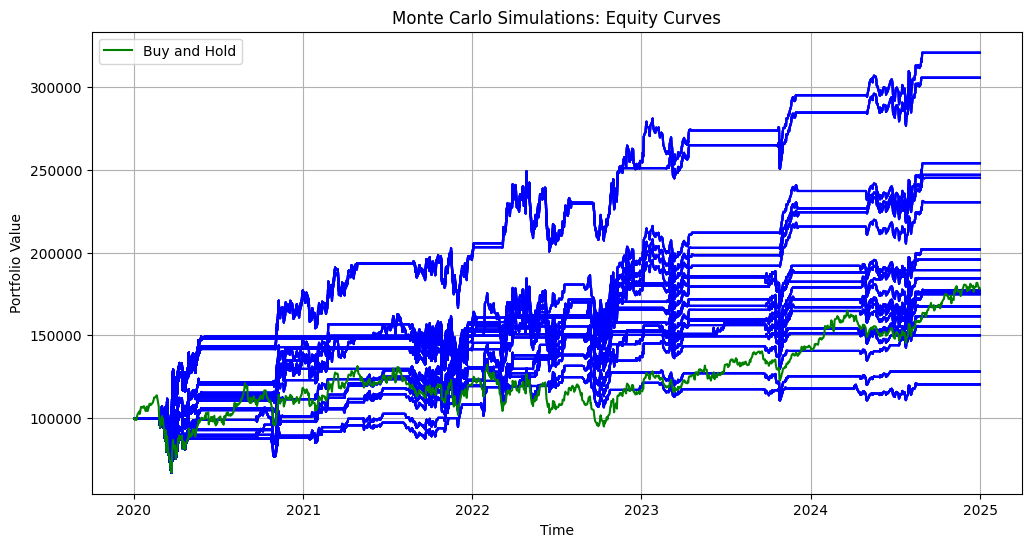

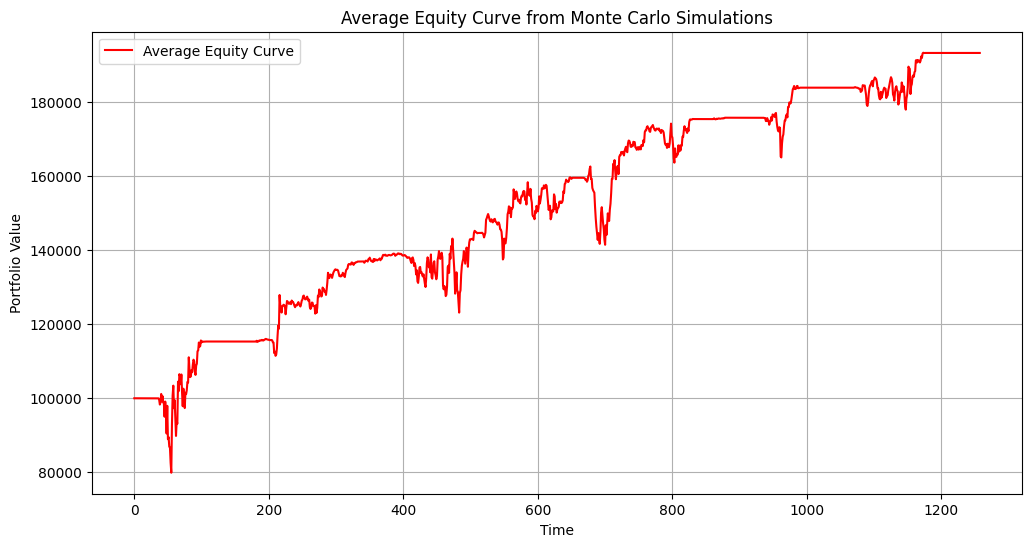

In [4]:
# Define the stock symbol and time period
symbol = 'MA'
start_date = '2020-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Monte Carlo Simulation parameters
n_simulations = 1000  # Number of simulations
initial_cash = 100_000  # Initial portfolio value
fee = 0.001  # Transaction fee

# Store performance results, equity curves, and best parameters
performance_results = []
equity_curves = []
best_params = None
best_return = -np.inf  # Initialize with very low return to find the best

# Run Monte Carlo simulation
for _ in range(n_simulations):
    # Randomize window sizes for Donchian Channels and RSI
    donchian_window = np.random.randint(10, 30)  # Random window size for Donchian Channels
    rsi_window = np.random.randint(10, 30)  # Random window size for RSI

    # Calculate Donchian Channels and RSI with randomized window sizes
    df_sim = df.copy()
    df_sim = calculate_donchian_channels(df_sim, window=donchian_window)
    df_sim = calculate_rsi(df_sim, window=rsi_window)

    # Define entry and exit signals based on Donchian Channels and RSI
    df_sim['Entry'] = (
        (df_sim['Close'] > df_sim['Lower']) &  # Price breaks above Lower Donchian Channel
        (df_sim['RSI'] < 30)  # RSI is below 30 (oversold condition)
    )

    df_sim['Exit'] = (
        (df_sim['Close'] < df_sim['Upper']) &  # Price breaks below Upper Donchian Channel
        (df_sim['RSI'] > 70)  # RSI is above 70 (overbought condition)
    )

    # Convert signals to boolean arrays
    entries_sim = df_sim['Entry'].to_numpy()
    exits_sim = df_sim['Exit'].to_numpy()

    # Backtest using vectorbt with the random parameters
    portfolio = vbt.Portfolio.from_signals(
        close=df_sim['Close'],
        entries=entries_sim,
        exits=exits_sim,
        init_cash=initial_cash,
        fees=fee
    )

    # Store the final portfolio value of this simulation
    performance_results.append(portfolio.total_return())
    equity_curves.append(portfolio.value())

    # Update best parameters if current simulation has better return
    if portfolio.total_return() > best_return:
        best_return = portfolio.total_return()
        best_params = (donchian_window, rsi_window)

# Print the best parameters
print(f"Best Donchian Window: {best_params[0]}")
print(f"Best RSI Window: {best_params[1]}")

# Analyze the results
performance_results = np.array(performance_results)
mean_return = np.mean(performance_results)
std_return = np.std(performance_results)
max_return = np.max(performance_results)
min_return = np.min(performance_results)

# Print performance statistics
print(f"Mean Return: {mean_return:.4f}")
print(f"Standard Deviation of Return: {std_return:.4f}")
print(f"Maximum Return: {max_return:.4f}")
print(f"Minimum Return: {min_return:.4f}")

# Calculate drawdown for each equity curve
drawdowns = []
max_drawdowns = []

for equity_curve in equity_curves:
    peak = np.maximum.accumulate(equity_curve)  # Track the peak value over time
    drawdown = (equity_curve - peak) / peak  # Calculate drawdown
    drawdowns.append(drawdown)
    max_drawdowns.append(drawdown.min())  # Store the maximum drawdown (most negative value)

# Convert drawdowns to a NumPy array for easier processing
max_drawdowns = np.array(max_drawdowns)

# Analyze drawdown statistics
mean_max_drawdown = np.mean(max_drawdowns)
std_max_drawdown = np.std(max_drawdowns)
max_drawdown = np.min(max_drawdowns)  # Most severe drawdown
min_drawdown = np.max(max_drawdowns)  # Least severe (closest to 0)

# Print drawdown statistics
print(f"Mean Maximum Drawdown: {mean_max_drawdown:.4f}")
print(f"Standard Deviation of Maximum Drawdown: {std_max_drawdown:.4f}")
print(f"Most Severe Maximum Drawdown: {max_drawdown:.4f}")
print(f"Least Severe Maximum Drawdown: {min_drawdown:.4f}")

# Calculate the buy-and-hold strategy equity curve
buy_and_hold_equity = initial_cash * (df['Close'] / df['Close'].iloc[0])

# Plot histogram of the returns from all simulations
plt.figure(figsize=(10, 6))
plt.hist(performance_results, bins=50, edgecolor='black', alpha=0.7)
plt.title('Monte Carlo Simulation Results')
plt.xlabel('Total Return')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# Plot histogram of the drawdowns from all simulations
plt.figure(figsize=(10, 6))
plt.hist(max_drawdowns, bins=50, edgecolor='black', alpha=0.7, color='orange')
plt.title('Monte Carlo Simulation: Drawdown Results')
plt.xlabel('Maximum Drawdown')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# Plot all drawdown curves from the simulations
plt.figure(figsize=(12, 6))
for drawdown in drawdowns:
    plt.plot(drawdown, alpha=0.1, color='red')
plt.title('Monte Carlo Simulations: Drawdown Curves')
plt.xlabel('Time')
plt.ylabel('Drawdown')
plt.grid()
plt.show()

# Analyze and visualize the average drawdown curve
average_drawdown_curve = np.mean(drawdowns, axis=0)
plt.figure(figsize=(12, 6))
plt.plot(average_drawdown_curve, color='purple', label='Average Drawdown Curve')
plt.title('Average Drawdown Curve from Monte Carlo Simulations')
plt.xlabel('Time')
plt.ylabel('Drawdown')
plt.legend()
plt.grid()
plt.show()

# Plot all equity curves from the simulations
plt.figure(figsize=(12, 6))
for equity_curve in equity_curves:
    plt.plot(equity_curve, alpha=0.1, color='blue')
plt.plot(buy_and_hold_equity, color='green', label='Buy and Hold')
plt.title('Monte Carlo Simulations: Equity Curves')
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid()
plt.show()

# Plot the average equity curve
average_equity_curve = np.mean(equity_curves, axis=0)
plt.figure(figsize=(12, 6))
plt.plot(average_equity_curve, color='red', label='Average Equity Curve')
plt.title('Average Equity Curve from Monte Carlo Simulations')
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid()
plt.show()

In [5]:
# Calculate Donchian Channels and RSI
df = calculate_donchian_channels(df, window=10)
df = calculate_rsi(df, window=25)

# Define entry and exit signals based on Donchian Channels and RSI
df['Entry'] = (
    (df['Close'] > df['Lower']) &  # Price breaks above Lower Donchian Channel
    (df['RSI'] < 30)  # RSI is below 30 (oversold condition)
)

df['Exit'] = (
    (df['Close'] < df['Upper']) &  # Price breaks below Upper Donchian Channel
    (df['RSI'] > 70)  # RSI is above 70 (overbought condition)
)

# Convert signals to boolean arrays
entries = df['Entry'].to_numpy()
exits = df['Exit'].to_numpy()

# Backtest using vectorbt
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=entries,
    exits=exits,
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'sharpe_ratio' requires frequency to be set
  warnings.warn(warning_message)
/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'calmar_ratio' requires frequency to be set
  warnings.warn(warning_message)
/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'omega_ratio' requires frequency to be set
  warnings.warn(warning_message)
/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'sortino_ratio' requires frequency to be set
  warnings.warn(warning_message)


Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                           320629.319157
Total Return [%]                       220.629319
Benchmark Return [%]                    78.483839
Max Gross Exposure [%]                      100.0
Total Fees Paid                       3095.174724
Max Drawdown [%]                        18.491136
Max Drawdown Duration                       200.0
Total Trades                                    7
Total Closed Trades                             7
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                                100.0
Best Trade [%]                          41.766089
Worst Trade [%]                          5.035365
Avg Winning Trade [%]                   18.864202
Avg Losing Trade [%]                          NaN
